In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.grimoire as Grimoire
from src.grimoire import By
import src.decks as Decks


In [2]:
commander = "Kodama of the West Tree"
# grim = Grimoire.Grimoire(omnicomprehensive=True)
# Decks.fetch(By.COMMANDER, commander,do_load=False,upper_limit=1000)
grim = Grimoire.fetch(By.COMMANDER,commander)


Carico le carte dal grimorio di Kodama of the West Tree


In [3]:
from src.card import Filters
# Crea la matrice di correlazione
df = grim.dataframe( 
    positive_filters=[
        Filters.isLegalInCommander,
        Filters.isCreature
    ], 
    negative_filters=[
        Filters.isToken
    ],
    additional_data={
        # "is_creature": lambda card: int(Type.Creature.name in card.types),
        # "#keywords" : lambda card: len(card.keywords),
        "#words" : lambda card: card.text.count(' ')+1,
        # "is_black": lambda card: int(card.color_identity['B']),
        # "is_white": lambda card: int(card.color_identity['W']),
        # "is_colorless": lambda card: int(all(not v for v in card.color_identity.values())),
        "is_legendary": lambda card: int("Legendary" in card.super_types),
        "#act_abilities": lambda card: int(card.count_active_abilities()),
        "#trigg_abilities": lambda card: int(card.count_trigger_abilities()),
        "#mana_production": lambda card: int(card.count_mana_production())
    })

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # type: ignore

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_scaled = df.copy()
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
df_scaled[numeric_cols] =  scaler.fit_transform(df[numeric_cols])
correlation_matrix = df_scaled.corr()

In [5]:
grim.remove(9092494)

True

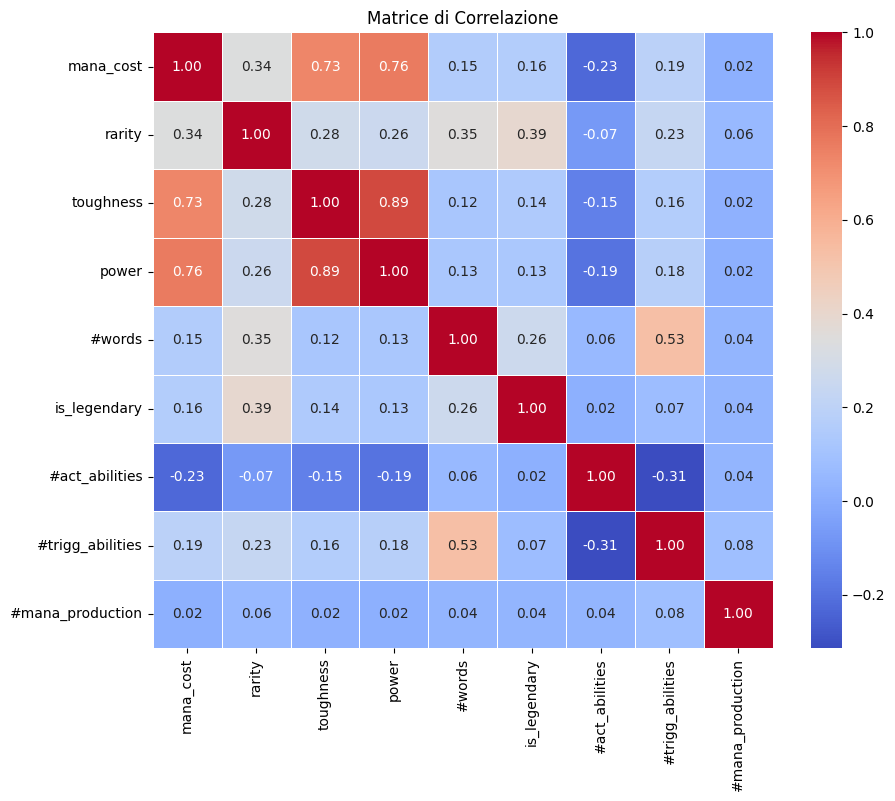

In [6]:
import numpy as np # type: ignore
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=np.round(correlation_matrix, 2), cmap='coolwarm', 
            linewidths=0.5, fmt=".2f", annot_kws={"size": 10})
plt.title('Matrice di Correlazione')
plt.show()


In [7]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np


# Funzione per aggiornare la heatmap
def update_heatmap(limit):
    # Crea una maschera booleana per nascondere le annotazioni non significative
    mask_annot = (correlation_matrix < -limit) | (correlation_matrix > limit)

    # Crea una matrice di annotazioni, sostituendo i valori non significativi con NaN
    annot = np.where(mask_annot, np.round(correlation_matrix, 2), np.nan)

    # Stampa la heatmap senza annotazioni per le celle non significative
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8}, mask=np.isnan(annot))
    plt.title(f'Heatmap with Limit: {limit}')
    plt.show()

# Crea un widget per limit
limit_slider = widgets.FloatSlider(value=0.15, min=0.00, max=0.23, step=0.001, description='Limit:')


# # Mostra la heatmap iniziale
# update_heatmap(limit_slider.value)

# Collega il widget alla funzione di aggiornamento
widgets.interactive(update_heatmap, limit=limit_slider)

interactive(children=(FloatSlider(value=0.15, description='Limit:', max=0.23, step=0.001), Output()), _dom_cla…

In [8]:
matrix = grim.similarity_matrix()
rows, cols = matrix.shape

if rows != cols:
    raise ValueError("La matrice non è quadrata.")
if not (matrix == matrix.T).all():
    raise ValueError("La matrice non è simmetrica.")
if (matrix < 0).any():
    raise ValueError("La matrice contiene valori negativi.")

In [9]:

# import imageio.v2 as imageio
# # Definisci i limiti per la GIF
# limits = np.arange(0, 0.24, 0.01)

# # Lista per salvare i frame
# frames = []

# # Genera i frame
# for limit in limits:
#     plt.figure(figsize=(10, 8))
    
#     # Crea una maschera booleana per nascondere le annotazioni non significative
#     mask_annot = (correlation_matrix < -limit) | (correlation_matrix > limit)

#     # Crea una matrice di annotazioni
#     annot = np.where(mask_annot, np.round(correlation_matrix, 2), np.nan)

#     # Stampa la heatmap
#     sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8}, mask=np.isnan(annot))
#     plt.title(f'Heatmap with Limit: {limit:.2f}')
    
#     # Salva il frame come immagine
#     plt.savefig(f'frame_{limit:.2f}.png')
#     plt.close()

#     # Aggiungi il frame alla lista
#     frames.append(imageio.imread(f'frame_{limit:.2f}.png'))

# # Crea una GIF animata
# imageio.mimsave('heatmap_animation.gif', frames, duration=4)

# # Rimuovi le immagini temporanee (opzionale)
# import os
# for limit in limits:
#     os.remove(f'frame_{limit:.2f}.png')

# print("GIF animata creata: heatmap_animation.gif")

/home/axten/.local/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/tmp/ipykernel_34578/2548900235.py:18: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distanze, method='complete'), labels=deck_ids)


Numero di cluster: 94


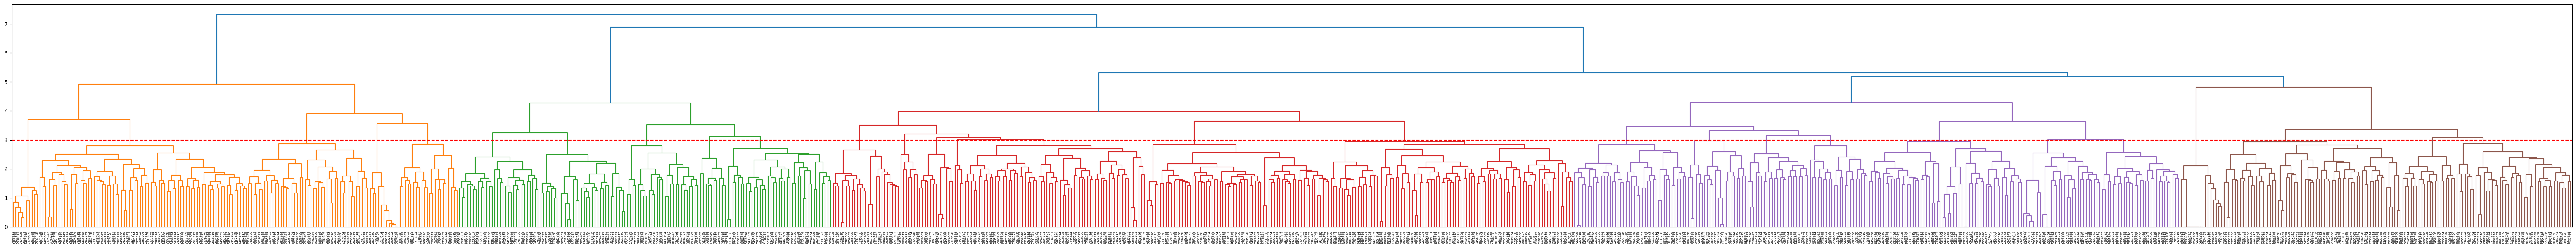

In [10]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

deck_ids = list(grim.get_all_deck_ids())
treshold = 3
model = AgglomerativeClustering(distance_threshold=treshold, n_clusters=None)

distanze = 1 - matrix
labels = model.fit_predict(distanze)

# Numero di cluster
n_clusters = len(set(labels))
print(f"Numero di cluster: {n_clusters}")

# Visualizza il dendrogramma
plt.figure(figsize=(80, 7))
dendrogram = sch.dendrogram(sch.linkage(distanze, method='complete'), labels=deck_ids)
plt.axhline(y=treshold, color='r', linestyle='--')  # Imposta una soglia per tagliare i cluster
plt.show()

In [11]:

# Stampa le etichette dei cluster per ogni punto
print("Etichette dei cluster:", labels)

# 4. Visualizza i dati e i cluster
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow')
plt.title('Agglomerative Hierarchical Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# 5. Visualizzazione del dendrogramma
linked = linkage(data, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Indice dei punti')
plt.ylabel('Distanza')
plt.show()

Etichette dei cluster: [24 10  0 90 39 26  1 90 85 63 68  1 62 63 13  1 10 56 61 31 26 80 48 69
 33  0  7 34  6 11 13 29 60 38 61 26 71 21 44 22 26 23  9  8 66 41 78 82
 52 26 13 31  0 19 48 76 76 60 34  3 33 32 49 34 28  6 76 88 65  7 56 64
 31 19 74 46 53 57 69  7 92 21 84 50 83 72 46 63  7 56 89 20 83 40 69 29
 24 19 84 73 44 91 40 80 24 20 46 83 74 62 49 38 79  3 85  6 39 63 49 13
 85 11 22 13 74 58 26 31  1 62 26 80 79  0 18 17 91  8 76 42 26 51 14 47
 36 52  8 52 31 10 69 85 54 48  9 20  1 45 69  0 69  7 29  4 18 60 23  0
 69 82 44  8 53 51 20 60 77  6  3 84 17 39 16 92 42 10 31 26 70  9 32 33
  8 63  6 27 28 13 60  7 31 70 11 69  1 69 72 76 91 40 49 89 90 12 31 34
 62 22  0 42 49 40 30 13 81  6 17 11 20 30 56 42 88 16 67  9 41 25 93 56
 93 10 27 16  4 60 22  6 48 42 35 20 59 12 35 69 42 76 15 84 15 63 10 27
  8 74 15 26 39 87 11  3 51 32 35 40  8 34 37 32 44 53 11  4 12 51 37 28
  3 22  3  5 64 20 48 38 31 52  8 15  8 13  0  9 31 56 86 90 88 19  6 32
 13 34  3 18 87 81 41 12 79 

NameError: name 'data' is not defined

In [12]:
# Controlla se ci sono valori negativi
if np.any(matrix > 1):
    print("La matrice di distanze contiene valori negativi.")

In [13]:

from sklearn.metrics import silhouette_score
# Calcola il silhouette score
score = silhouette_score(distanze, labels, metric='precomputed')
print(f'Silhouette Score: {score:.3f}')

Silhouette Score: -0.016


In [ ]:

from scipy.cluster.hierarchy import linkage

# Clustering agglomerativo
Z = linkage(distanze, method='average')

# Calcola le distanze per il metodo del gomito
max_distanze = []
for i in range(1, len(matrix)):
    # Aggiungi la distanza massima dal dendrogramma
    max_distanze.append(max(Z[:i, 2]))

# Grafico del metodo del gomito
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(matrix)), max_distanze, marker='o')
plt.title('Metodo del Gomito per Clustering Agglomerativo')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Distanza Massima')
plt.grid()
plt.show()